In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from omegaconf import OmegaConf
import numpy as np

from model import Model
from dataset import *
from utils import *
from model import Model

from torchtnt.utils.device import copy_data_to_device

dataset  = "CELEBA"
root = "./experiment_a"
device = "cuda:1"

with open(f"{root}/.hydra/config.yaml", "r") as f:
    cfg = OmegaConf.load(f)

# Load CLIP

In [2]:
import clip

#clip.available_models()
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.to(device).eval()
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Load our model

In [3]:
module = Model(
    dim=cfg.model.dim,
    alpha=cfg.train.loss_coefs.alpha,
    beta=cfg.train.loss_coefs.beta,
    device=device,
).to(device)

state_dict = torch.load(os.path.join(root, "state_dict.pt"), map_location="cpu")
module.load_state_dict(state_dict)

trainloader = get_loader(dataset, "train", cfg.train.batch_size, num_workers=cfg.train.num_workers, pin_memory=cfg.train.pin_memory)
testloader  = get_loader(dataset, "test", cfg.val.batch_size, num_workers=cfg.train.num_workers, pin_memory=cfg.train.pin_memory)

/tmp/ipykernel_87548/1679638070.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(root, "state_dict.pt"), map_location="cpu")


In [4]:
module.forget()
for data in trainloader:
    data = copy_data_to_device(data, device=device)
    with torch.no_grad():
        output = module(data)
module.update_minterms()

In [5]:
embeddings = []
images = []
labels = []
for data in testloader:
    data = copy_data_to_device(data, device=device)
    images.append(data.images)
    labels.append(data.labels)
    with torch.no_grad():
        embeddings.append(module.embed(data))
embeddings = torch.cat(embeddings, dim=0)
images = torch.cat(images, dim=0)
labels = torch.cat(labels)

In [6]:
from sklearn.metrics import average_precision_score

query = "Eyeglasses and Male and not Wearing_Necktie and Bald"
literals = [l.strip() for l in query.split("and")]

pos_literals = [l for l in literals if "not" not in l]
neg_literals = [l.replace("not", "").strip() for l in literals if "not" in l]

pos_idx = [testloader.dataset.class_to_idx[l] for l in pos_literals]
neg_idx = [testloader.dataset.class_to_idx[l] for l in neg_literals]

masks = [module._minterms[:,idx] == 1 for idx in pos_idx]
masks.extend([module._minterms[:,idx] == 0 for idx in neg_idx])

mask = masks[0]
for i in range(len(masks)):
    mask = torch.logical_and(mask, masks[i])

projection = module._minterm_vecs[mask].T @ module._minterm_vecs[mask]

p = torch.einsum("bi,ij,bj->b", embeddings, projection, embeddings)
idx = torch.argsort(p, descending=True)
target = torch.logical_and((labels[:,pos_idx] == 1).all(-1), (labels[:,neg_idx] == 0).all(-1))

ap = average_precision_score(target.cpu(), p.cpu())
precision = target[idx[:10]].sum() / 10
print(f"AP = {ap}")
print(f"Precision@10 = {precision}")

AP = 0.5783837359443346
Precision@10 = 0.9000000357627869


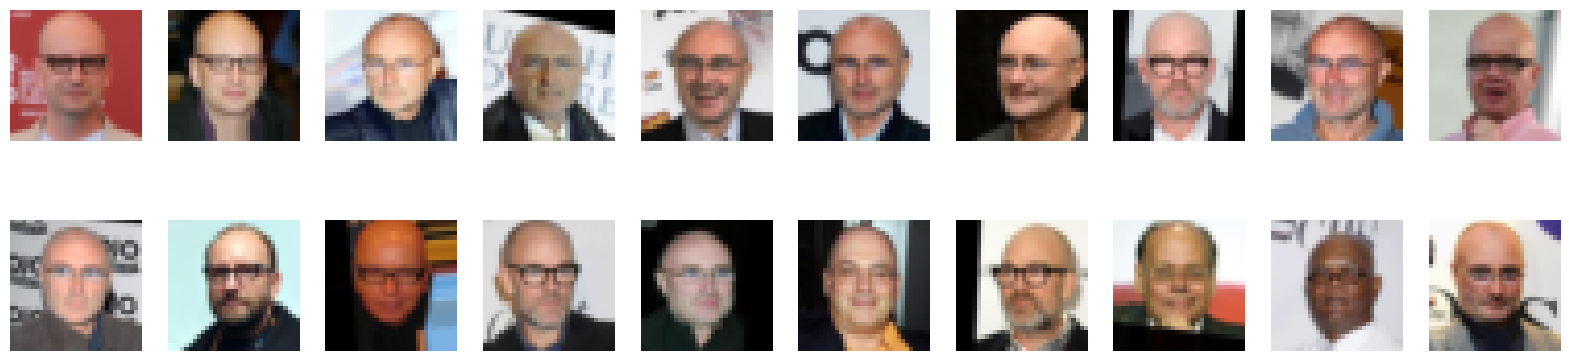

In [7]:
n = 20
plt.figure(figsize=(20,5))
for i in range(n):
    plt.subplot(2,n//2,i+1)
    plt.imshow(images[idx[i]].permute(1,2,0).cpu())
    plt.axis("off")

# CLIP retrieval

In [8]:
from torchvision.transforms.functional import resize, normalize

clip_img_embeddings = []
for data in testloader:
    data = copy_data_to_device(data, device=device)
    with torch.no_grad():
        preprocessed = resize(data.images, 224)
        preprocessed = normalize(preprocessed,
                                 mean=(0.48145466, 0.4578275, 0.40821073),
                                 std=(0.26862954, 0.26130258, 0.27577711))
        clip_img_embeddings.append(clip_model.encode_image(preprocessed).float())
clip_img_embeddings = torch.cat(clip_img_embeddings, dim=0)

In [9]:
with torch.no_grad():
    text_tokens = clip.tokenize(["bald male with eyeglasses not wearing a necktie"]).to(device)
    clip_text_embedding = clip_model.encode_text(text_tokens).float()

clip_img_embeddings /= clip_img_embeddings.norm(dim=-1, keepdim=True)
clip_text_embedding /= clip_text_embedding.norm(dim=-1, keepdim=True)
similarity = (clip_text_embedding @ clip_img_embeddings.T).squeeze()
idx = torch.argsort(similarity.squeeze(), descending=True) 

ap = average_precision_score(target.cpu(), similarity.cpu())
precision = target[idx[:10]].sum() / 10

print(f"AP = {ap}")
print(f"Precision@10 = {precision}")

AP = 0.2885993860940367
Precision@10 = 0.30000001192092896


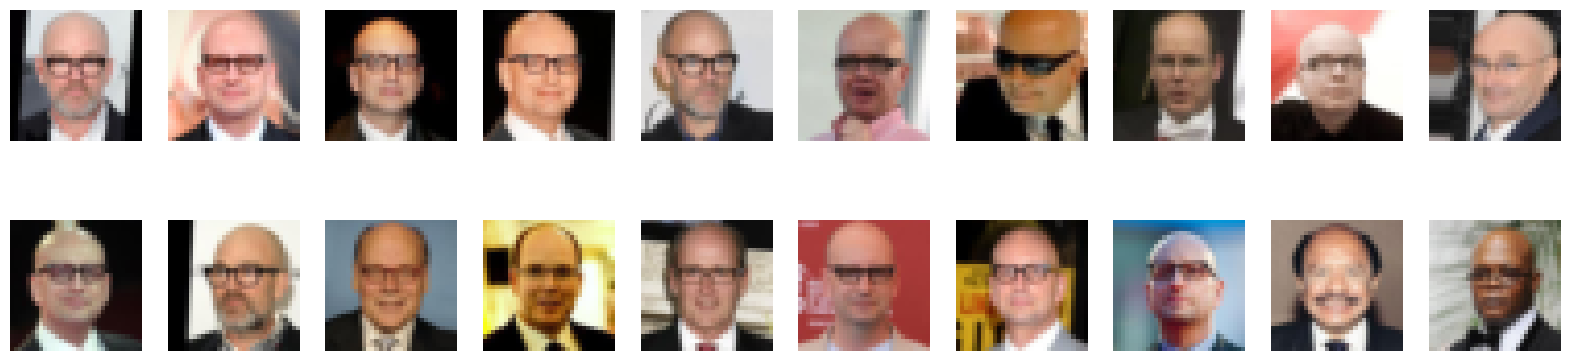

In [10]:
n = 20
plt.figure(figsize=(20,5))
for i in range(n):
    plt.subplot(2,n//2,i+1)
    plt.imshow(images[idx[i]].permute(1,2,0).cpu())
    plt.axis("off")

In [245]:
labels[idx[0]]

tensor([0, 0, 1, 1, 1], device='cuda:1')

# Precision-Recall Curves

In [ ]:
mask = (minterms[:,trainloader.dataset.class_to_idx['Wearing_Hat']] == 1)
idx = np.random.randint(len(testloader.dataset))
p = torch.square(minterms_vec[mask,:] @ F.normalize(x[idx,:], p=2, dim=0)).sum().item()
plt.figure()
plt.imshow(testloader.dataset[idx][0])
plt.title("{:.3f}".format(p))
plt.axis('off')

In [ ]:
label = "Wearing_Necktie"
mask = (minterms[:,trainloader.dataset.class_to_idx[label]] == 1)
subspace = minterms_vec[mask,:]

p = torch.square(F.normalize(x, p=2, dim=-1) @ subspace.T).sum(dim=-1).cpu()

y_label = y[:,testloader.dataset.class_to_idx[label]].cpu()
idx = torch.where(torch.logical_and(y_label, p < 0.5))[0]

plt.figure(figsize=(20,30))
testloader.dataset.transform = None
for i in range(200):
    plt.subplot(20,10,i+1)
    plt.imshow(testloader.dataset[idx[i]][0])
    plt.axis('off')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Retrieval

In [ ]:
p = compute_minterms_probabilities(x, minterms_vec)

In [ ]:
bald = 0
glasses = 0
tie = 0
hat = 1
male = 0

In [ ]:
i = torch.where((minterms == torch.tensor([bald,glasses,tie,hat,male])).all(dim=-1))[0].item()
idx = torch.argsort(p[:,i].squeeze(), descending=True)

num_retrieved = 12*3
fig = plt.figure(figsize=(11,3))
for j in range(num_retrieved):
    plt.subplot(3,12,j+1)
    testloader.dataset.transform = None
    plt.imshow(testloader.dataset[idx[j]][0])
    plt.axis('off')
    #plt.title("{:.2f}".format(p[idx[j],i].item()))
#plt.suptitle(minterms_str[i], fontsize=20)
plt.tight_layout()
fig.savefig(os.path.join(EXP_ROOT, minterms_str[i] + ".png"))

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.imshow((x @ x.T)**2, cmap="GnBu", vmin=0.0, vmax=1.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.set_ticks(np.linspace(0, 1, 5))
cb.ax.set_yticklabels(np.linspace(0, 1, 5))
plt.axis('off')
fig.savefig(os.path.join("cifar10_experiments", EXP_NAME, "_test_embeddings_inner.pdf"))